# An Analysis Site Design's Impact on RateBeer.com Review Contributions
#### jhh283, sjh293

## Abstract
Preece and Schneiderman's Reader-to-Leader Framework (RTLF) [1] details a number of usability and sociability factors that sites can deploy to help promote contributions of user generated content (UGC). In particular, the paper describes "visibility for...contributions" as a motivating factor for ongoing contributions of UGC, along with a "recognition of quality and quantity of contributions." Beenen et al. (2004) [2], building on Karau and William's Collective Effort Model [3], also demonstrated that highlighting the "uniqueness" of contributions on the MovieLens review site was correleated with an increase in UGC on the site. 

This notebook's analysis focuses on RateBeer.com, one of the leading beer review websites, and in particular on a major overhaul of the site's user profile pages in May 2009. RateBeer's 2009 profile page redesign made numerous substantial improvements in line with recommendations offered in the RTLF paper. While the total number of reviews contributed by a user were long included on review pages, in forums posts, and on profile pages, the redesign went to great lengths to expose additional layers of detail about each user's contributions, better highlighting the uniqueness, completeness, and quality of each user's corpus of beer reviews.

Based on the findings in the Preece and Schneiderman's RTLF, we hypothesized that a substantial site redesign which incorporated Preece and Schneiderman's recommendations would result in a measureable increase in the quantity and diversity of UGC. More specifically, the increased visibility on profile pages after May 2009 of a user's beer review variants, the introduction of an activity stream, and clearer presentation of a user's contributions, all in line with RTLF recommendations, would result in a corresponding increase in contributions within at most a year after the launch date.

[1]: Preece, Jennifer and Ben Shneiderman (2009). “The Reader-to-Leader Framework: Motivating Technology-Mediated Social Participation,” in Transactions on Human-Computer Interaction.

[2]: Breece et al (2004). "Using Social Psychology to Motivate Contributions to Online Communities." Paper presented at Computer-Supported Cooperative Work and Social Computing (CSCW) November 6-10, 2004, Chicago, Illinois, USA

[3]: Karau, S. and K. Williams, Social loafing: A meta-analytic review and theoretical integration. Journal of Personality and Social Psychology, 1993. 65(4): p. 681-706.

#### Notebook helper functions and imports

In [1]:
import os

from IPython.display import HTML
from IPython.display import display, Image
from PIL import Image as PILImage

def files_at_relpath(rel_path):
    return [os.path.join(rel_path, f) for f in os.listdir(rel_path)]


def display_images(img_path, **kwargs):
    scale = kwargs.get('scale')
    if scale is not None:
        kwargs.pop('scale', None)
    kwargs.pop("key", None)
    files = files_at_relpath(img_path)
    for filename in files:
        try:
            if scale is None:
                display(Image(filename=filename, **kwargs))
            else:
                w, h = None, None
                with PILImage.open(filename) as imgfile:
                    w, h = imgfile.size
                kwargs['width'] = float(w) * scale
                kwargs['height'] = float(h) * scale
                display(Image(filename=filename, **kwargs))
        except ValueError as e:
            continue

## Introduction


## RateBeer.com 2009 User Profile Redesign
In an effort to confirm our hypothesis, we identified RateBeer redesigns that adhered to the RTLF principles. To pinpoint these redesigns, and to allow for a comparison of the site before and after the redesign, we scanned page archives captured by the Way Back Machine service (archive.org). We quickly realized that many site redesigns were incremental, and that large, site wide redesigns were comparatively rare occerence. One particular redesign did stick out, however, and that was the update to user profile pages launched by RateBeer administrators beginning on May 3, 2009 (forum posts from that time suggest the feature was rolled out of a period of a few weeks)[4].

[4] "Love the New Format on the Userpage..." RateBeer.com, 3 May 2009. Web. 28 Apr. 2015. <http://www.ratebeer.com/forums/love-the-new-format-on-the-userpage_115257.htm>.

### RateBeer.com Profile Pages
* April 2009 profile page (user MiP): https://web.archive.org/web/20090425001049/http://www.ratebeer.com/View-User-10185.htm
* August 2009 profile page (user MiP): https://web.archive.org/web/20090822202711/http://www.ratebeer.com/View-User-10185.htm

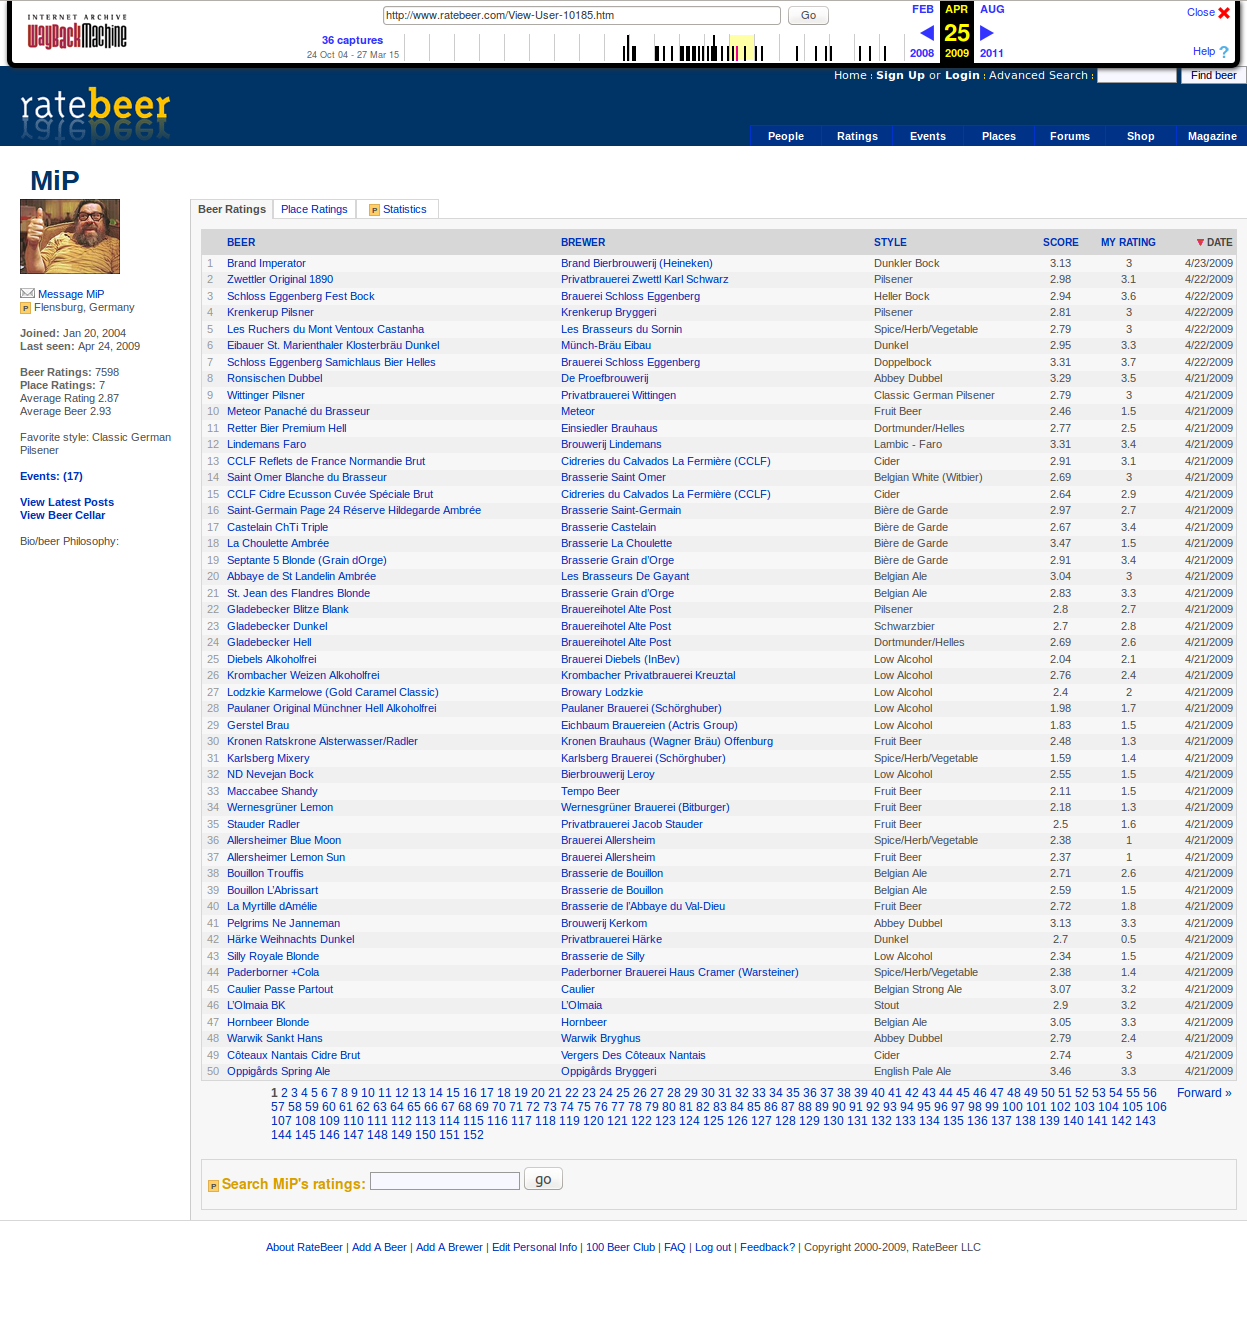

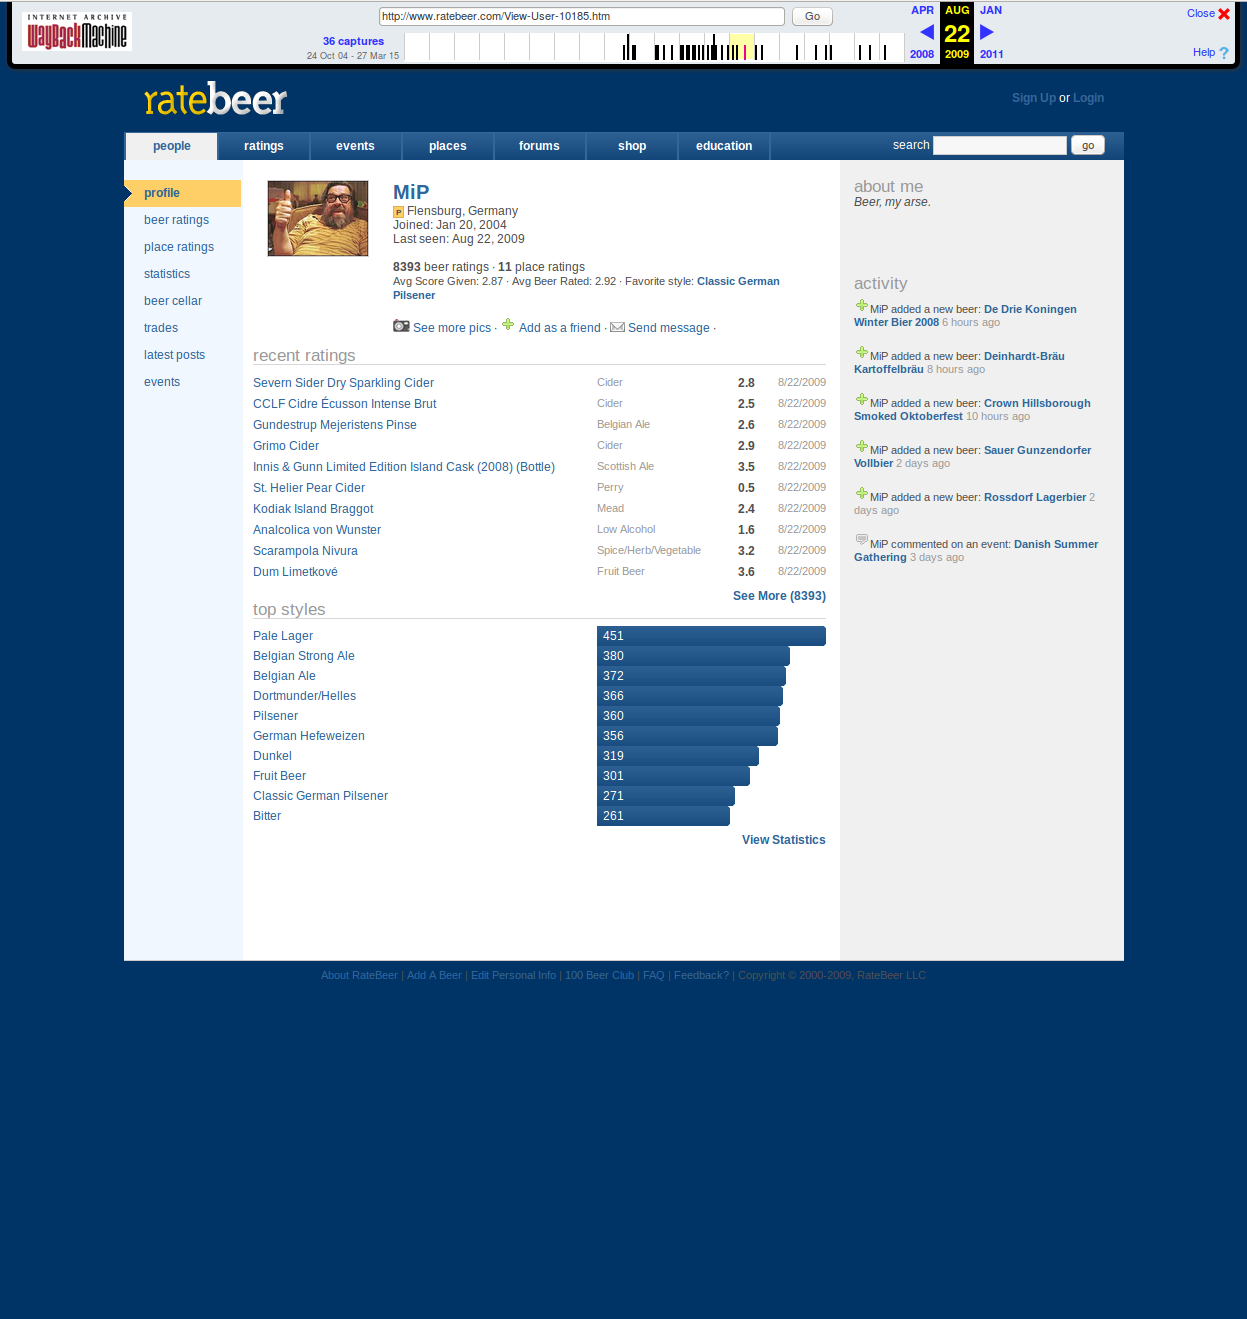

In [2]:
display_images('images/ratebeer/profiles-MiP/', scale=0.7)

### Activity Stream and Top Styles
These two screen captures above show a heavy user's profile as it appeared on April (figure 1, above) and August of 2009 (figure 2, above). Aside from the aesthetic changes, several key changes stand out. Most notable is the introduction of a new "activity" stream (figure 3, below). This feature is a sort of automated social awareness stream of an individual's UGC across the site, likely inspired by the success of Facebook around this time. Furthermore, while statistics were previously available behind the "Statistics" tab on the old site, RateBeer replaced the simple reverse chronological listing of reviews with an interesting summary of the user's  contributions by beer style. This beer style chart, standing clearly out on its white background, also draws attention to a more prominent link to the full page of statistics.

In their MovieLens study, Breece et al. explain that "the collective effort model posits that people will socially loaf less when they perceive that their contribution is important to the group...if they think they are unique, they should be more motivated to contribute." [3] The top styles chart in particular, and the increased emphasis on each user's contribution characteristics over the plain listing of reviews more generally, appears to be designed to better represent the uniqueness of each contributor. These features allow "contributors to stand out," as Preece and Schneiderman put it.

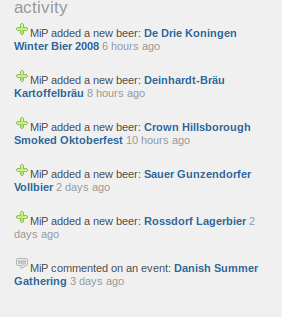

In [3]:
display_images('images/ratebeer/activity-MiP/')

##Data Source

The dataset used for this assignment was provided by Julian McAuley and was found using the links suggested in the assginment (http://jmcauley.ucsd.edu/cse255/data/beer/Ratebeer.txt.gz). This data was collected as a part of the following studies (https://snap.stanford.edu/data/web-RateBeer.html):

[1] J. McAuley, J. Leskovec, and D. Jurafsky. Learning attitudes and attributes from multi-aspect reviews. ICDM, 2012.

[2] J. McAuley and J. Leskovec. From amateurs to connoisseurs: modeling the evolution of user expertise through online reviews. WWW, 2013.

This dataset includes 2924164 user-provided reviews from the RateBeer website from the period of time 04/12/2000 to 01/13/2012. For the purposes of our analysis, we filtered the dataset down to a period of time +/- 1 year from the feature change date of 05/01/2009 (so 5/1/2008 - 5/1/2010) so that we could capture user behavior before and after the change. This narrows our dataset to be 801276 reviews from 9453 users. 

Note: Throughout our code, we assume that the file 'data/reduced_data.txt' has been generated. This can be generated using the ParseBeerData notebook.

In [4]:
# Example Dataset Review Entry
__ = {
    'beer/ABV': 7.2,
    'beer/beerId': '59261',
    'beer/brewerId': '67',
    'beer/name': 'Sierra Nevada Torpedo Extra IPA',
    'beer/style': 'India Pale Ale &#40;IPA&#41;',
    'review/appearance': 1.0,
    'review/aroma': 0.8,
    'review/overall': 0.9,
    'review/palate': 0.8,
    'review/taste': 1.0,
    'review/text': 'Aroma is lemon and orange citrus, reddish orange hue, flavor is very well balanced between the malt and hop. this beer is very drinkable. It is not "over the top" like some of the double ipas. The alcohol content is well contained. The finish is hoppy as one would expect for this style. An excellent beer from the folks at Sierra Nevada!',
    'review/timeStruct': {
        'hour': 0,
        'isdst': 0,
        'mday': 17,
        'min': 0,
        'mon': 2,
        'sec': 0,
        'wday': 1,
        'yday': 48,
        'year': 2009
    },
   'review/timeUnix': 1234828800,
   'user/profileName': 'Blazhock'
}

## Data Processing
Below are a collection of functions which operate on the pre-sorted, filtered dataset prepared by our parsing code. The dataset is filtered to a date range specified in that parsing code, and sorted by 

In [5]:
%matplotlib inline

import json
from itertools import groupby
from collections import defaultdict
from datetime import date, datetime

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import numpy as np

In [6]:
"""
Constants for data processing
"""
SOURCE_FILE = 'data/reduced_data.txt'
SORTED_FILE = 'data/sorted_data.txt'

START_DATE = date(2008,5,1)
END_DATE = date(2010,5,1)
LAUNCH_DATE = date(2009,5,3)

### Helper functions

In [7]:
"""
Helper to return unicode string as ascii with special characters removed.
"""
def clean_unicode(instr):
    return unicodedata.normalize('NFKD', instr).encode('ascii', 'ignore') 

"""
Helper to parse and yield data from file to json
"""
def parse_json(filename, normalize=True):
    with open(filename) as f:
        for line in f:
            out = json.loads(line, encoding='latin-1')
            if normalize:
                temp = {}
                for key in out:
                    try:
                        key = clean_unicode(key)
                    except:
                        key = key
                    try:
                        temp[key] = clean_unicode(out[key])
                    except:
                        temp[key] = out[key]
                out = temp
            yield out
    f.close()
    
# via http://matplotlib.org/examples/pylab_examples/finance_work2.html
def moving_average(x, n, type='simple'):
    """
    compute an n period moving average.

    type is 'simple' | 'exponential'

    """
    x = np.asarray(x)
    if type=='simple':
        weights = np.ones(n)
    else:
        weights = np.exp(np.linspace(-1., 0., n))

    weights /= weights.sum()


    a =  np.convolve(x, weights, mode='full')[:len(x)]
    a[:n] = a[n]
    return a    

### RateBeer Reviews by Date
This collection of functions produces a summary of the total number of reviews per day within the sample dataset. This aggregation is conducted on the pre-sorted data set, prepared during the parsing stage. This dataset is intended to help review the site-wide trends in UGC generation before and after the launch of the new RateBeer profiles in May 2009.

In [8]:
# Sorted data doesn't fit comfortably in memory. This function provides access to an iterator over the data.
def sorted_data_iter():
    return parse_json(SORTED_FILE)

In [9]:
timestamp_keyfunc = lambda r: r.get('review/timeUnix')
date_keyfunc = lambda r: date.fromtimestamp(r.get('review/timeUnix'))

def groupby_daily(sorted_reviews):
    reviews_by_date = {}
    for key, group in groupby(sorted_reviews, date_keyfunc):
        reviews_by_date[key] = len(list(group))
    return reviews_by_date

In [10]:
reviews_by_date = groupby_daily(sorted_data_iter())

In [52]:
dates = sorted(reviews_by_date.keys())
review_counts = [reviews_by_date[k] for k in dates]

# Moving average of review counts by day
ma_days = 45
ma = moving_average(review_counts, ma_days, 'exponential')

# Linear trendline of review counts by day
polynomial_order = 3
trend_line = np.polyfit(range(len(dates)), review_counts, polynomial_order)

In [12]:
"""
Groups reviews by month
"""
user_keyfunc = lambda r: r.get('user/profileName')

def month_keyfunc(review):
    # Return the first day of the month for any day in a month
    review_date = date.fromtimestamp(review.get('review/timeUnix'))
    return date(review_date.year, review_date.month, 1)

def groupby_monthly(sorted_reviews):
    monthly_user_count = {}
    for key, group in groupby(sorted_reviews, month_keyfunc):
        user_sorted = sorted(group, key=user_keyfunc)
        monthly_user_count[key] = len(list(groupby(user_sorted, user_keyfunc)))
    return monthly_user_count

In [13]:
monthly_user_count = groupby_monthly(sorted_data_iter())
months = sorted(monthly_user_count.keys())
user_counts = [monthly_user_count[m] for m in months]

In [14]:
"""
Groups reviews by month, then by beer/style.
"""
beer_style_keyfunc = lambda r: r.get(u'beer/style')

def groupby_styles_monthly(sorted_reviews):
    monthly_beer_count = {}
    all_styles = {}
    for key_month, group in groupby(sorted_reviews, month_keyfunc):
        style_sorted = sorted(group, key=beer_style_keyfunc)
        monthly_beer_count[key_month] = {}
        for key_style, subgroup in groupby(style_sorted, beer_style_keyfunc):
            style_count = len(list(subgroup))
            monthly_beer_count[key_month][key_style] = style_count
            all_styles[key_style] = all_styles.setdefault(key_style, 0) + style_count
    return monthly_beer_count, all_styles

In [15]:
monthly_beer_count, all_styles = groupby_styles_monthly(sorted_data_iter())

In [16]:
"""
Maintain detailed monthly review counts for the top N styles. 
Styles below this N threshold are aggregated into the new 'Other' category.
"""
N_styles = 10
top_N_styles = sorted(all_styles.items(), key=lambda s: s[1], reverse=True)[0:N_styles]
top_styles = [s[0] for s in top_N_styles]

months = sorted(monthly_beer_count.keys())
style_counts = {}

for style in top_styles:
    month_counts = []
    for month in months:
        month_counts.append(monthly_beer_count[month][style])
    style_counts[style] = month_counts
    
# Aggregation of reviews for beers that are not in top_N_styles
other_counts = []
for i in range(len(months)):
    month = months[i]
    # Total of all reviews
    total_reviews = sum(monthly_beer_count[month].values())
    # Total count of reviews for top_styles beers
    top_style_reviews = sum([style_counts[s][i] for s in top_styles])
    other_counts.append(total_reviews - top_style_reviews)
#     other_counts.insert(0, total_reviews - top_style_reviews)
style_counts['Other'] = other_counts
top_styles.insert(0, 'Other')

In [60]:
# print [months[i] for i in range(len(months))]
# print other_counts

# Linear trendline of review counts by day
polynomial_order = 2
other_style_trend_line = np.polyfit(range(len(months)), other_counts, polynomial_order)
print other_style_trend_line

[  3.72464275e+00  -9.57589571e+01   2.07791715e+04]


## Site Wide Results

In [18]:
current_palette = sns.color_palette("Paired", 10)

In [19]:
def plot_reviews(dates, review_counts, ma, ma_days, trend_line, polynomial_order, current_palette):

    fig, axes = plt.subplots(1, figsize=(16, 10))

    # Review count plot
    axes.plot(dates, review_counts, color=current_palette[1], lw=1, label='Daily reviews')
    axes.fill_between(dates, 0, review_counts, facecolor=current_palette[0], alpha=0.8)
    # Review count plot
    axes.plot(dates, ma, color=current_palette[3], lw=4, alpha=0.75, label=('%d day moving avg.' % ma_days))
    # N order linear model plot
    axes.plot(dates, np.polyval(trend_line, range(len(dates))), color=current_palette[5], lw=4, alpha=0.75, label=('Order %d linear model' % polynomial_order))
    
    axes.annotate("Profile redesign",
                  xy=(LAUNCH_DATE, 0),
                  xytext=(LAUNCH_DATE, 500),
                  arrowprops=dict(arrowstyle="->"),
                  fontsize='large'
                 )

    # Labels and axes formatting
    axes.set_title('RateBeer Reviews by Date')
    axes.set_xlabel('Dates')
    axes.set_ylabel('Reviews')
    fig.autofmt_xdate()
    axes.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
    handles, labels = axes.get_legend_handles_labels()
    axes.legend(handles, labels)

    plt.show()

### RateBeer Reviews over Time
The chart below plots the total quantity of reviews by the RateBeer community before and after the launch of the new profile page in May 2009. The x-axis represents individual days within our sample data set, while the y-axis represents the total number of reviews contributed by RateBeer users on that date.  The launch date of the new profile pages is annotated on the x-axis for reference.

In an effort to better portray the trend of reviews over the time period of our sample set, which included all reviews +/- 1 year from the launch of the new profile pages, we also calculated a 45-day moving average of daily review totals. The moving average (red trend line) provides a cleaner depiction of the fluctuations in contribution of new reviews over time. The overall trend over the full time period is best represented by the linear model we fit to the full dataset (blue trendline).

These results indicate that, contrary to our hypothesis, there was no measurable increase in UGC corresponding with the launch of the new RateBeer user profile pages. If anything, the linear model suggets that reviews were trending somewhat downwards towards the end of our sample set.

*Note*: The chart below shows a clear gap in the sample set over a period of time in late December 2008. While this appeared to be a processing error at first glance, further investigation suggested that it reflects a period of downtime resulting from attacks on the RateBeer site around that time. [1]


[1]: "Bottoms Up." Bottoms Up Oddbits Ratebeer Hacked Sam Loses Money New Beers Coming Our Way Comments. Bottoms Up, 6 Nov. 2008. Web. 28 Apr. 2015. <http://www.ibabuzz.com/bottomsup/2008/11/06/oddbits-ratebeer-hacked-sam-loses-money-new-beers-coming-our-way/>.

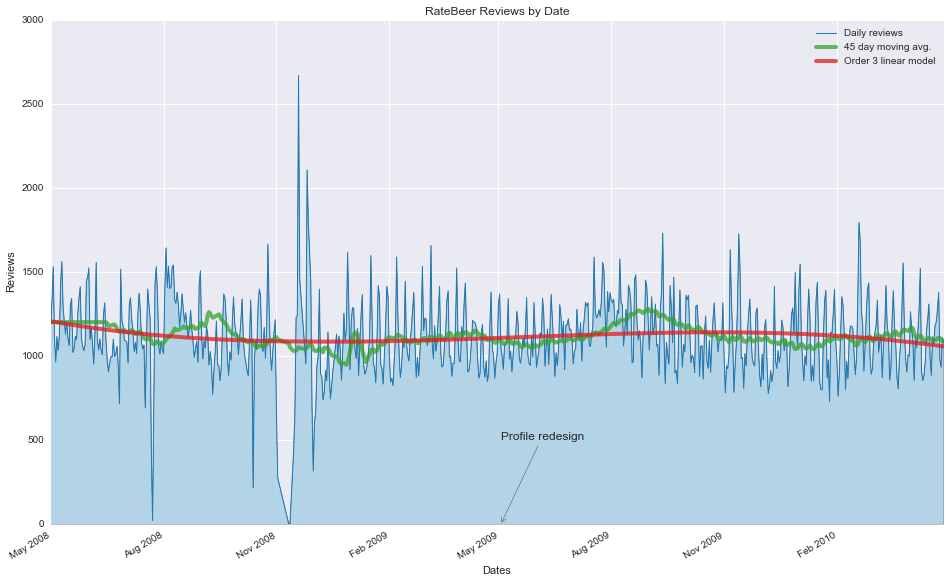

In [20]:
plot_reviews(dates, review_counts, ma, ma_days, trend_line, polynomial_order, current_palette)

In [21]:
def plot_users_monthly(months, user_counts, current_palette):
    fig, axes = plt.subplots(1, figsize=(16, 10))

    axes.plot(months, user_counts, color=current_palette[3], lw=1, label='Unique users')
    axes.fill_between(months, 0, user_counts, facecolor=current_palette[2], alpha=0.8)
    
    axes.annotate("Profile redesign",
              xy=(LAUNCH_DATE, 0),
              xytext=(LAUNCH_DATE, 500),
              arrowprops=dict(arrowstyle="->"),
              fontsize='large'
             )

    fig.autofmt_xdate()
    axes.set_title('RateBeer Unique Users by Month')
    axes.set_xlabel('Months')
    axes.set_ylabel('Users')
    axes.fmt_xdata = mdates.DateFormatter('%Y-%m')
    plt.show()

### RateBeer Unique Users by Month
The chart below represents the count of unique users that contributed at least 1 review during each month within our sample dataset. Again, the x-axis represents time (on a monthly time scale in this case), while the y-axis represents the total number of users that contributed UGC within that month. This data, likewise, provides little support for our hypothesis. 

These result, while they provide no meaningful support for our hypothesis, do make intuitive sense. It seems sensible that updates to user profile pages would not have a dramatic impact on the total number of users. Rather, we expected to see a increase in the quantity of contributions by existing contributors, so this relatively flat trend in total unique users over time is unsurprising.

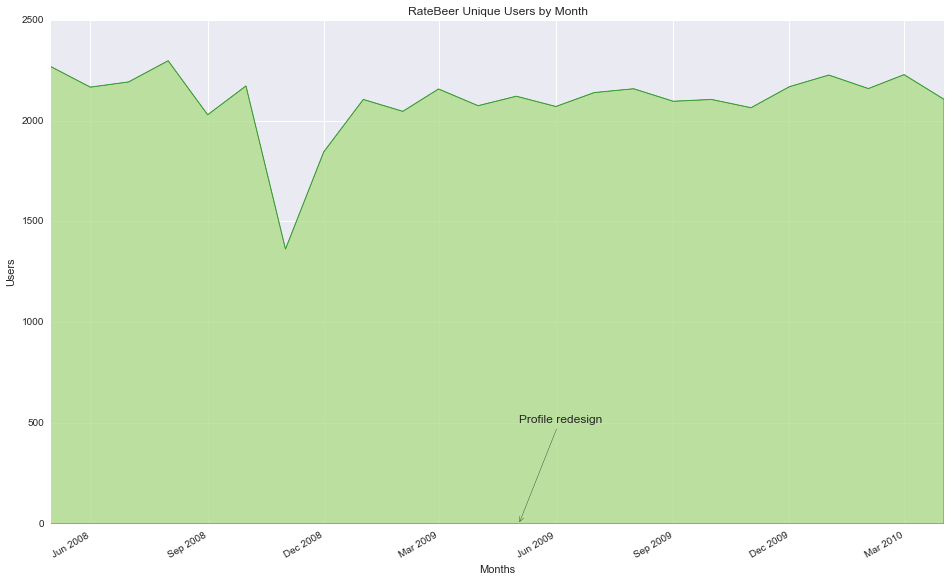

In [22]:
plot_users_monthly(months, user_counts, current_palette)

In [23]:
users_html = ["""<table>
<tr>
<th>Date</th>
<th>User Counts</th>
</tr>"""]
for i in range(len(months)):
    users_html.append("""<tr><td>%s</td><td>%s</td></tr>""" % (months[i], "{:,}".format(user_counts[i])))
users_html.append("""</table>""")

h = HTML(''.join(users_html)); h

Date,User Counts
2008-05-01,"2,268"
2008-06-01,"2,166"
2008-07-01,"2,192"
2008-08-01,"2,297"
2008-09-01,"2,029"
2008-10-01,"2,172"
2008-11-01,"1,363"
2008-12-01,"1,845"
2009-01-01,"2,105"
2009-02-01,"2,046"


In [24]:
current_palette = sns.color_palette("hls", len(top_styles))

In [25]:
def plot_styles_monthly(months, style_counts, current_palette):
    fig, axes = plt.subplots(1, figsize=(16, 10))

    area_bottoms = [0 for i in range(len(months))]
    cp_index = 0
    for style in top_styles:
        area_tops = [style_counts[style][j] + area_bottoms[j] for j in range(len(months))]

        axes.plot(months, area_tops, color=current_palette[cp_index], lw=1, label=('%s' % style))
        axes.fill_between(months, area_bottoms, area_tops, facecolor=current_palette[cp_index], alpha=0.8)

        area_bottoms = list(area_tops)
        cp_index += 1

    axes.set_title('RateBeer Style Reviews by Date')
    axes.set_xlabel('Dates')
    axes.set_ylabel('Reviews')
    fig.autofmt_xdate()
    axes.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
    handles, labels = axes.get_legend_handles_labels()
    axes.legend(handles, labels, loc=8, ncol=2, frameon=True, markerscale=5.0, fontsize='large', title='Beer Styles')

    plt.show()

### RateBeer Beer Style Review Trends by Month
In addition to analyzing the total quantity of reviews site wide, we also analyzed the diversity of contributions by RateBeer users. Specifically, we looked at the relative volume of reviews for the top 10 most popular beer styles, as compared to reviews for "other" beer styles outside the top 10. Given that the user profile page displayed a chart of the user's reviews by style, we expected to see the rate of reviews of "other" style to increase following the redesign. In other words, we expected that the redesign would highlight the uniqueness of user contributions, and thus promote yet more unique contributions from users.

The 2 charts below again show the total number of reviews by RateBeer users over time, grouped by month. On both charts, the y-axis represents the total number of reviews for that beer style in the corresponding month. The top chart below compares the quantity of reviews for the top 10 styles against reviews for the "other" styles. As the chart demonstrates, the top 10 styles represent about 30-40% of all reviews across the site.


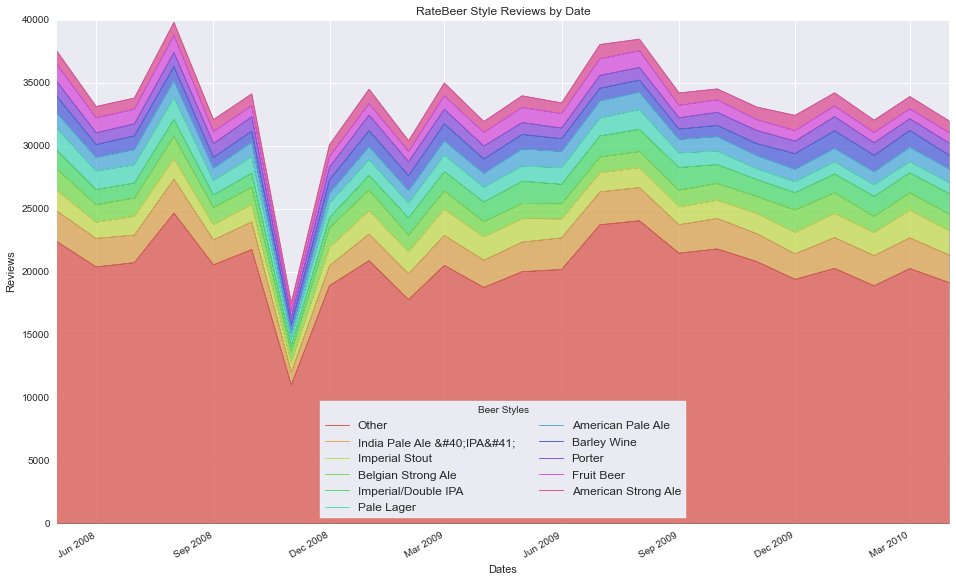

In [26]:
plot_styles_monthly(months, style_counts, current_palette)

In [72]:
styles_html = ['<table><tr>']
styles_html.append('<th></th>')  # Blank upper left corner
for month in months:
    styles_html.append(
        ('<th>%s</th>' % month.strftime('%b %Y'))
    )
styles_html.append('</tr>')

# First half
for style in top_styles[:len(top_styles)/2]:
    styles_html.append(('<tr><td>%s</td>' % style))
    for i in range(len(months)):
        styles_html.append(('<td>%s</td>' % ('{:,}'.format(style_counts[style][i]))))
    styles_html.append('</tr>')
styles_html.append('</table>')

# Second half
styles_html.append('<table><tr>')
styles_html.append('<th></th>')  # Blank upper left corner
for month in months:
    styles_html.append(
        ('<th>%s</th>' % month.strftime('%b %Y'))
    )
styles_html.append('</tr>')

for style in top_styles[len(top_styles)/2:]:
    styles_html.append(('<tr><td>%s</td>' % style))
    for i in range(len(months)):
        styles_html.append(('<td>%s</td>' % ('{:,}'.format(style_counts[style][i]))))
    styles_html.append('</tr>')
styles_html.append('</table>')

h = HTML(''.join(styles_html)); h

,May 2008,Jun 2008,Jul 2008,Aug 2008,Sep 2008,Oct 2008,Nov 2008,Dec 2008,Jan 2009,Feb 2009,Mar 2009,Apr 2009,May 2009,Jun 2009,Jul 2009,Aug 2009,Sep 2009,Oct 2009,Nov 2009,Dec 2009,Jan 2010,Feb 2010,Mar 2010,Apr 2010
Other,"22,410","20,385","20,729","24,660","20,552","21,765","11,016","18,898","20,884","17,792","20,506","18,757","20,011","20,180","23,732","24,051","21,476","21,814","20,809","19,398","20,267","18,891","20,260","19,133"
India Pale Ale (IPA),"2,417","2,265","2,185","2,685","1,984","2,197","1,014","1,587","2,113","2,055","2,382","2,159","2,344","2,513","2,606","2,633","2,261","2,418","2,215","2,027","2,450","2,395","2,430","2,195"
Imperial Stout,"1,668","1,284","1,492","1,638","1,208","1,364",770,"1,456","1,861","1,739","2,081","1,854","1,854","1,502","1,519","1,581","1,416","1,445","1,608","1,702","1,923","1,834","2,204","1,940"
Belgian Strong Ale,"1,679","1,394","1,447","1,772","1,364","1,381",828,"1,551","1,632","1,328","1,456","1,203","1,214","1,199","1,254","1,279","1,327","1,335","1,357","1,780","1,636","1,284","1,380","1,303"
Imperial/Double IPA,"1,490","1,202","1,191","1,337",992,"1,120",519,797,"1,163","1,360","1,528","1,567","1,762","1,549","1,673","1,760","1,793","1,500","1,337","1,374","1,494","1,580","1,589","1,619"
,May 2008,Jun 2008,Jul 2008,Aug 2008,Sep 2008,Oct 2008,Nov 2008,Dec 2008,Jan 2009,Feb 2009,Mar 2009,Apr 2009,May 2009,Jun 2009,Jul 2009,Aug 2009,Sep 2009,Oct 2009,Nov 2009,Dec 2009,Jan 2010,Feb 2010,Mar 2010,Apr 2010
Pale Lager,"1,748","1,471","1,450","1,751","1,143","1,317",547,"1,167","1,258","1,193","1,322","1,176","1,207","1,323","1,418","1,574","1,160","1,082",856,872,962,921,883,880
American Pale Ale,"1,210","1,083","1,201","1,333",979,"1,129",530,801,"1,038",975,"1,120","1,099","1,364","1,289","1,362","1,377","1,083","1,136","1,047",982,"1,071","1,034","1,149","1,083"
Barley Wine,"1,320","1,014","1,093","1,108",857,893,574,"1,046","1,252","1,188","1,349","1,140","1,145","1,004","1,002",956,812,886,942,"1,239","1,387","1,300","1,318","1,087"
Porter,"1,184",933,952,"1,117","1,093","1,137",583,"1,003","1,240","1,103","1,157","1,021",944,848,"1,021","1,006",894,"1,040","1,041",996,"1,122",996,937,961


In [70]:
def plot_other_styles_monthly(months, other_count, other_style_trend_line, current_palette, top_N_num):
    fig, axes = plt.subplots(1, figsize=(16, 10))
    
    axes.plot(months, other_count, color=current_palette[0], lw=1, label='Reviews')
    axes.fill_between(months, 0, other_count, facecolor=current_palette[1], alpha=0.8)
    axes.plot(months, np.polyval(other_style_trend_line, range(len(months))), color=current_palette[5], lw=4, alpha=0.75, label='Linear model')
    
    
    axes.annotate("Profile redesign",
              xy=(LAUNCH_DATE, 0),
              xytext=(LAUNCH_DATE, 5000),
              arrowprops=dict(arrowstyle="->"),
              fontsize='large'
             )

    fig.autofmt_xdate()
    axes.set_title(('RateBeer Reviews of "Other" Beer Styles Outside Top %d Styles' % (top_N_num)))
    axes.set_xlabel('Months')
    axes.set_ylabel('"Other" Style Reviews')
    axes.fmt_xdata = mdates.DateFormatter('%Y-%m')
    plt.show()
    

### RateBeer Beer Style Review Trends by Month (cont.)
This second chart display only the "other" beer review totals, separated from the top 10 styles. This graph also adds a linear model, fit to the monthly "other" reviews data, which summarizes the general trend in review totals within this category. The flat trend, seen on the charts above and below, in contributions of "other" style beer reviews before and after the profile page redesign again contradicts our hypothesis that the diversity of contributions would increase following the redesign.

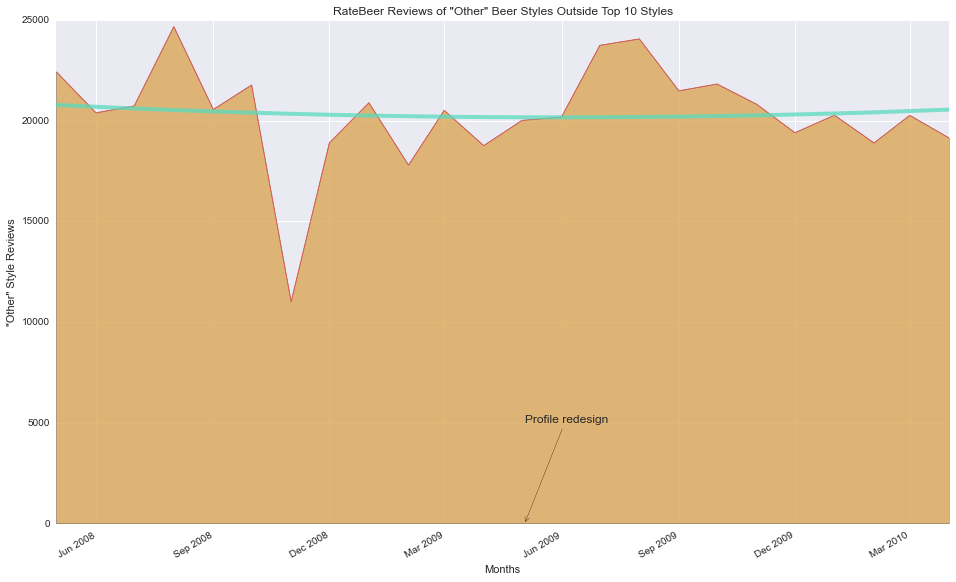

In [71]:
plot_other_styles_monthly(months, other_counts, other_style_trend_line, current_palette, N_styles)

##User Level Results

In addition to looking at site-level impact, we also hypothesized that the website changes may have altered the way that individual users engaged with and contributed to the overall community. This portion of the analysis looks at trends in select features and identifies how a user's contribution level before the remodel correlated with observed contribution changes after. 

We conclude this section by building a classification model to predict (based on a user's contributions before the "split") how the number of reviews contributed by the user change after the "split" [frome hereon referred to as "pre-split" and "post-split"].We test several different linear classifiers and evaluate how predictive the features identified really are. 

For the purposes of this analysis, we focused on the following user feature variables:
* Number of Reviews Posted - Users more commited to the community will post more reviews
* Review Diversity - Users who are more engaged will post more and more diverse information
    * Types of Beers - Count
    * Rating Scores - Number of Different, Average
    * Review Length - Number of Different, Average

###Data Parsing

In [30]:
# import statements
import unicodedata
import random
import calendar
import math
import operator

In [31]:
"""
A variety of helper methods to group data structures accordingto 
"""
def groupby_key(data, key_str):
    key_map = {}
    for datum in data:
        key = datum.get(key_str)
        key_map[key] = key_map.setdefault(key, [])
        key_map[key].append(datum)
    return key_map

def groupby_key_count(data, key_str, func=None):
    key_map = {}
    for datum in data:
        key = datum.get(key_str)
        try:
            key = func(key)
        except: 
            key = key
        key_map[key] = key_map.setdefault(key, 0) + 1
    return key_map

def group_time_split(user_array, key, func=None):
    return [[groupby_key_count(time_per, key, func) for time_per in user] for user in user_array]

"""
Reservoir sampling given an iterable input and k for number of items to be sampled
"""
def reservoir_sample(iterator, k):
    iterator = iter(iterator)
    # fill the reservoir to start
    result = [next(iterator) for _ in range(k)]
    n = k
    for item in iterator:
        n += 1
        s = random.randint(0, n)
        if s < k:
            result[s] = item
    return result
"""
Calculates the average using dictionary keys as "values" and dictionary values as "counts"
"""
def avg_from_map(keymap):
    count, total, a = 0, 0, None
    for key in keymap:
        if (key):
            count += keymap[key]
            total += key * keymap[key]
    if (count):
        a = total / count
    return a
"""
average from user tuple array
"""
def avg_from_user_array_tuple(array):
    out = []
    for user in array:
        user_avg = []
        for time in user:
            count, total, a = 0, 0, None
            for item in time:
                count += item[1]
                total += item[0] * item[1]
            if count > 0: 
                a = total/count
            user_avg.append(a) 
        out.append(user_avg)
    return out

In [32]:
# Parse and read in dataset from reduced_data.txt (as produced by our parsing code)
parsed_red = parse_json('data/reduced_data.txt', normalize=True)
dset = [i for i in parsed_red]

In [33]:
# parse dataset, grouping reviews by username
users = groupby_key(dset,'user/profileName')
user_vals = users.values()
print 'number of users', len(user_vals)

# split each users' group of reviews into two buckets: before and after site changes
user_vals_split = []
split_timestamp = calendar.timegm(datetime(2009,5,1).timetuple())

for i , posts in enumerate(user_vals):
    pre = [post for post in posts if post.get('review/timeUnix') < split_timestamp]
    post = [post for post in posts if post.get('review/timeUnix') >= split_timestamp]
#     Only look at users who already contributed in the prior period
    if len(pre) > 0:
        user_vals_split.append([pre, post])

# sort reviews according to the number of reviews users contributed before 
user_vals_split = sorted(user_vals_split, key=lambda user: len(user[0]))
print 'number of users post split', len(user_vals_split)

number of users 9440
number of users post split 6203


###High-level Feature Trends
As we brainstormed features which may reflect a user's engagement level, we eventually settled on the following variables: number of reviews contributed, review diversity (types of beers being reviewed), average review rating (score), and average review length (word count). 

Specifically, we were interested in seeing how each of these variables changed "pre-split" to "post-split" based on the user's relative amount of reviews contributed "pre-split". 

In order to look at these features, we sorted the user dataset based on the number of reviews each user contributed "pre-split" and calculated a plus-minus value for each of the variables we looked at (plus-minus calculated as value_post_split - value_pre_split). We then plotted these values for the entire population and calculated mean, median, and standard deviation.

Over the course of our analysis, we noticed that high-usage users typically exhibited more extreme changes in plus-minus. For this reason, we also performed the mean/median/stdev analysis for the top 5% of users. In order to provide a control for these high-usage users, we paired the high-usage statistics with the numbers for a ramdomly sampled group of the same size from the entire dataset as well as the "long tail" of 95% other users.

In [34]:
# sample "top" 5% and "low" 95% of users
users_top = user_vals_split[int(math.floor(len(user_vals_split)*0.95)):]
users_low = user_vals_split[:int(math.floor(len(user_vals_split)*0.95))]

# sample "random" user group to be equal to the "top" group
sample_size = len(users_top)
users_sampled = reservoir_sample(user_vals_split, sample_size)

In [35]:
"""
Plot utility to plot the users's plus minus
Prints out the mean, median, and standard deviation for the plus minus 
"""
def plot_diff(user_list, func=lambda x: x, plot=True):
    user_pre = [func(user[0]) for user in user_list]
    user_post = [func(user[1]) for user in user_list]

    np_pre = np.array(user_pre)
    np_post = np.array(user_post)
    np_pm = np_post - np_pre
    print "Mean p/m: ", np.mean(np_pm)
    print "Median p/m: ", np.median(np_pm)
    print "Std Dev p/m: ", np.std(np_pm)

    ind = np.arange(len(np_pm))
    if (plot):
        fig, ax = plt.subplots()
        scatt = ax.scatter(ind, np_pm, c="grey",s=10,edgecolor='none')
        mean = ax.axhline(y=np.mean(np_pm),xmin=0,xmax=ind[len(ind) - 1],c="blue",linewidth=0.9, linestyle = '-', zorder=1, label='mean')
        median = ax.axhline(y=np.median(np_pm),xmin=0,xmax=ind[len(ind) - 1],c="red",linewidth=0.9,linestyle = '--', zorder=2, label='median')
        plt.legend(loc=3, ncol=2)

#### Review Counts
Based on the results below, we notice that, across the board, user contribution (as measured by review count) seem to have decreased after the profile-page change (counter what we would have predicted based on the increased behavioral incentive on the profile page). This includes users who didn't contribute in the second period at all (reflecting a lack of user retention). 

We notice that, on average, high-usage users seem to have skewed the overall average review count downwards as the average "high-usage" user had a review count decrease of 76 as compared to ~3 for both the long-tail and the random sample group (which makes sense considering a finite cap in number of beers to be reviewed). We do notice that there does appear to be a fair number of "mid-usage" users who did have the number of reviews contributed increase after the change.

all user review counts
Mean p/m:  -6.55311945833
Median p/m:  -2.0
Std Dev p/m:  95.9040989895

top user review counts 311
Mean p/m:  -75.3504823151
Median p/m:  -88.0
Std Dev p/m:  290.009750348

low user review counts 5892
Mean p/m:  -2.92175831636
Median p/m:  -2.0
Std Dev p/m:  70.5739092616

sampled user review counts 311
Mean p/m:  -8.19935691318
Median p/m:  -3.0
Std Dev p/m:  85.6242377838



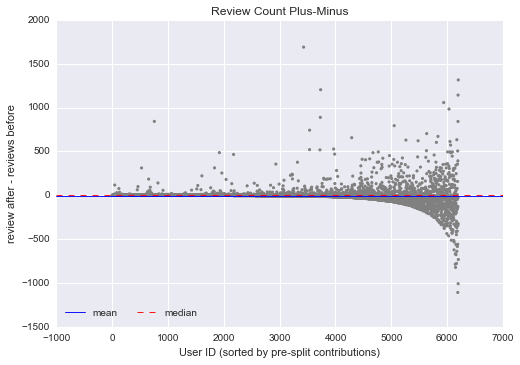

In [36]:
# review counts
# all users stats
print 'all user review counts'
plot_diff(user_vals_split, lambda x: len(x))
plt.xlabel('User ID (sorted by pre-split contributions)')
plt.ylabel('review after - reviews before')
plt.title('Review Count Plus-Minus')
print

# top users stats
print 'top user review counts', len(users_top)
plot_diff(users_top, lambda x: len(x), False)
print

# low users stats
print 'low user review counts', len(users_low)
plot_diff(users_low, lambda x: len(x), False)
print

# sampled users stats
print 'sampled user review counts', len(users_sampled)
plot_diff(users_sampled, lambda x: len(x), False)
print

In [37]:
# remove users who did not post reviews after the split (for rest of metrics)
users_split_active = [user for user in user_vals_split if len(user[1]) > 0]
users_top_active = users_split_active[int(math.floor(len(users_split_active)*0.95)):]
users_low_active = users_split_active[:int(math.floor(len(users_split_active)*0.95))]
users_sampled_active = reservoir_sample(users_split_active, len(users_top_active))

#### Average Number of Beer Styles Reviewed
Based on the results below, we notice that, across the board, the average number of beer styles reviewed decreased after the profile-page change (consistent with the way that the new page encourages users to specialize). However, part of this change may have to do with the overall decrease in number of reviews, so it doesn't appear conclusive. We notice that, on average, high-usage users have a steeper drop in style count than the whole and random sample. 

Looking at the plot, we notice that there does appear to be a distinct pattern of having "low-contribution" users be more likely to have a positive plus-minus in this variable than "high-contribution" users. This makes sense as "low-usage" users have more beers available to them to review while "high-usage" users have less or the fact that "high-usage" users are more aware of their profile page. This seems to support the inconclusive nature of this feature. 

all users style counts
Mean p/m:  -2.11114946496
Median p/m:  -2.0
Std Dev p/m:  14.9416100897

top users style counts
Mean p/m:  -3.89655172414
Median p/m:  -2.0
Std Dev p/m:  9.5763531594

low users style counts
Mean p/m:  -2.01707848837
Median p/m:  -2.0
Std Dev p/m:  15.165944931

sample users style counts
Mean p/m:  -1.04137931034
Median p/m:  -1.0
Std Dev p/m:  15.5585106379



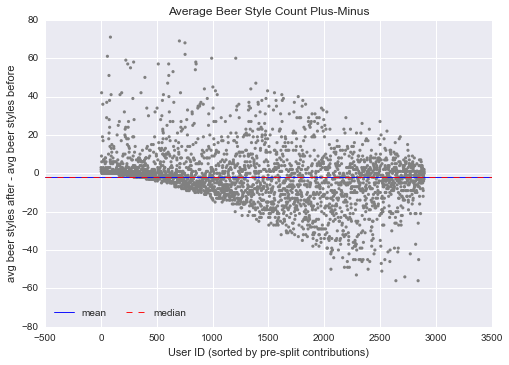

In [38]:
# average number of styles reviewed before/after change
print 'all users style counts'
styles_all = group_time_split(users_split_active, 'beer/style')
# want number of styles
styles_all = map(lambda x: [len(x[0].keys()), len(x[1].keys())], styles_all)
plot_diff(styles_all)
plt.xlabel('User ID (sorted by pre-split contributions)')
plt.ylabel('avg beer styles after - avg beer styles before')
plt.title('Average Beer Style Count Plus-Minus')
print

print 'top users style counts'
styles_top = group_time_split(users_top_active, 'beer/style')
# want number of styles
styles_top = map(lambda x: [len(x[0].keys()), len(x[1].keys())], styles_top)
plot_diff(styles_top, lambda x: x, False)
print

print 'low users style counts'
styles_low = group_time_split(users_low_active, 'beer/style')
# want number of styles
styles_low = map(lambda x: [len(x[0].keys()), len(x[1].keys())], styles_low)
plot_diff(styles_low, lambda x: x, False)
print

print 'sample users style counts'
styles_samp = group_time_split(users_sampled_active, 'beer/style')
# want number of styles
styles_samp = map(lambda x: [len(x[0].keys()), len(x[1].keys())], styles_samp)
plot_diff(styles_samp, lambda x: x, False)
print

#### Average Overall Rating
Based on the results below, we notice that, across the board, the average overall rating very slightly increased after the profile-page change. However, the increase is very small (smaller than 1%), and seems to reflect that the profile page change didn't markedly impact ratings. 

We note that the standard deviation for high-usage users is significantly smaller for this variable (perhaps due to longtime users have an anchoring affect to what ratings "should" be or having less reviews in the second period).

all users rating avg
Mean p/m:  0.00766111070627
Median p/m:  0.00759347568569
Std Dev p/m:  0.110952097262

top users rating avg
Mean p/m:  0.0104611243546
Median p/m:  0.00786606563649
Std Dev p/m:  0.0280117434344

low users rating avg
Mean p/m:  0.00751358091738
Median p/m:  0.00753205128205
Std Dev p/m:  0.113653907282

sampled users rating avg
Mean p/m:  0.00982520690135
Median p/m:  0.0112280701754
Std Dev p/m:  0.092900691391



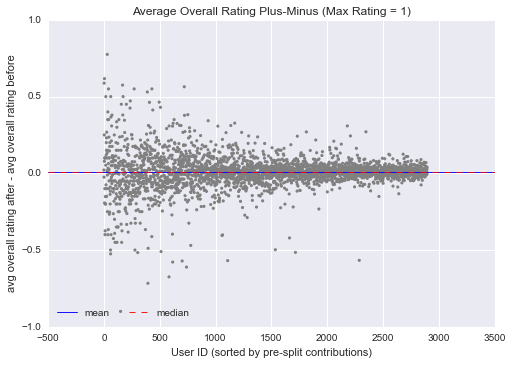

In [39]:
# average overall ratings before/after change
print 'all users rating avg'
rates_all = group_time_split(users_split_active, 'review/overall', lambda x: float(x))
rates_all = map(lambda x: [[(rating,  x[0][rating]) for rating in x[0].keys()], [(rating,  x[1][rating]) for rating in x[1].keys()]], rates_all)
avg_rates = avg_from_user_array_tuple(rates_all)
plot_diff(avg_rates)
plt.xlabel('User ID (sorted by pre-split contributions)')
plt.ylabel('avg overall rating after - avg overall rating before')
plt.title('Average Overall Rating Plus-Minus (Max Rating = 1)')
print

print 'top users rating avg'
rates_top = group_time_split(users_top_active, 'review/overall', lambda x: float(x))
rates_top = map(lambda x: [[(rating,  x[0][rating]) for rating in x[0].keys()], [(rating,  x[1][rating]) for rating in x[1].keys()]], rates_top)
avg_rates = avg_from_user_array_tuple(rates_top)
plot_diff(avg_rates, lambda x: x, False)
print

print 'low users rating avg'
rates_low = group_time_split(users_low_active, 'review/overall', lambda x: float(x))
rates_low = map(lambda x: [[(rating,  x[0][rating]) for rating in x[0].keys()], [(rating,  x[1][rating]) for rating in x[1].keys()]], rates_low)
avg_rates = avg_from_user_array_tuple(rates_low)
plot_diff(avg_rates, lambda x: x, False)
print

print 'sampled users rating avg'
rates_samp = group_time_split(users_sampled_active, 'review/overall', lambda x: float(x))
rates_samp = map(lambda x: [[(rating,  x[0][rating]) for rating in x[0].keys()], [(rating,  x[1][rating]) for rating in x[1].keys()]], rates_samp)
avg_rates = avg_from_user_array_tuple(rates_samp)
styles_plot = plot_diff(avg_rates, lambda x: x, False)
print

#### Average Review Length
Based on the results below, we notice that, across the board, the average review length very slightly increased after the profile-page change. However, the increase is very small (smaller than 1 word), and seems to reflect that the profile page change didn't markedly impact review length. 

We note that the standard deviation for high-usage users is significantly smaller for this variable (perhaps due to longtime users have an anchoring affect to what reviews "should" be or having less reviews in the second period).

all users review length avg
Mean p/m:  0.910942354159
Median p/m:  0.0
Std Dev p/m:  18.9860241745

top users review length avg
Mean p/m:  0.675862068966
Median p/m:  0.0
Std Dev p/m:  8.47624083775

low users review length avg
Mean p/m:  0.923328488372
Median p/m:  0.0
Std Dev p/m:  19.3822925352

sampled users review length avg
Mean p/m:  0.910344827586
Median p/m:  1.0
Std Dev p/m:  17.0042255363



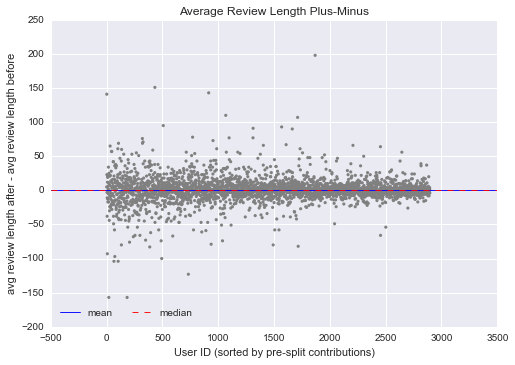

In [40]:
# average review lengths before/after change
print 'all users review length avg'
reviews_all = group_time_split(users_split_active, 'review/text', lambda x: float(x))
reviews_all = map(lambda x: [[(len(review.split()),  x[0][review]) for review in x[0].keys()], [(len(review.split()),  x[1][review]) for review in x[1].keys()]], reviews_all)
avg_review_len = avg_from_user_array_tuple(reviews_all)
styles_plot = plot_diff(avg_review_len)
plt.xlabel('User ID (sorted by pre-split contributions)')
plt.ylabel('avg review length after - avg review length before')
plt.title('Average Review Length Plus-Minus')
print

print 'top users review length avg'
reviews_top = group_time_split(users_top_active, 'review/text', lambda x: float(x))
reviews_top = map(lambda x: [[(len(review.split()),  x[0][review]) for review in x[0].keys()], [(len(review.split()),  x[1][review]) for review in x[1].keys()]], reviews_top)
avg_review_len = avg_from_user_array_tuple(reviews_top)
styles_plot = plot_diff(avg_review_len, lambda x: x, False)
print

print 'low users review length avg'
reviews_low = group_time_split(users_low_active, 'review/text', lambda x: float(x))
reviews_low = map(lambda x: [[(len(review.split()),  x[0][review]) for review in x[0].keys()], [(len(review.split()),  x[1][review]) for review in x[1].keys()]], reviews_low)
avg_review_len = avg_from_user_array_tuple(reviews_low)
styles_plot = plot_diff(avg_review_len, lambda x: x, False)
print

print 'sampled users review length avg'
reviews_samp = group_time_split(users_sampled_active, 'review/text', lambda x: float(x))
reviews_samp = map(lambda x: [[(len(review.split()),  x[0][review]) for review in x[0].keys()], [(len(review.split()),  x[1][review]) for review in x[1].keys()]], reviews_samp)
avg_review_len = avg_from_user_array_tuple(reviews_samp)
styles_plot = plot_diff(avg_review_len, lambda x: x, False)
print


###Explore Potential  Correlation
Based on the earlier high-level analysis performed, it seemed apparent that some of the features visibly exhibited patterns suggesting some form of correlation. In order to further explore this idea, we performed a correlation analysis (focusing on linear correlation) on each "pre-split" feature -- total number of reviews, number of styles reviewed, average overall rating, number of distinct ratings, average review length, and number of distinct review lengths. 

For each of these features, we calculated the pearson correlation coefficient against both the number of post-split reviews and the review count plus-minus for each user.

####Setting up Feature Vectors

In [41]:
# build feature vectors
x, y_after, y_diff = [], [], []
for user in user_vals_split:
    pre_char = user[0]
    style_map = groupby_key_count(pre_char, 'beer/style')
    rating_map = groupby_key_count(pre_char, 'review/overall')
    review_map = groupby_key_count(pre_char, 'review/text', lambda x : len(x.split()))
    total_count = len(pre_char)
    style_count = len(style_map.keys())
    avg_rating = avg_from_map(rating_map)
    rating_count = len(rating_map.keys())
    avg_review = avg_from_map(review_map)
    review_count = len(review_map.keys())
    # throw away points that don't have rating / review
    if (avg_rating is not None and avg_review is not None):
        x.append([total_count, style_count, avg_rating, rating_count, avg_review, review_count])
        y_after.append(len(user[1]))
        y_diff.append(len(user[1])-len(user[0]))
data_pool = zip(x,y_diff)

In [42]:
def balance_pool(pool):
    """
    Given a pool of year-key formatted unbalanced outcome data, return a balanced set where positive outcomes have equal number of occurances to negative outcomes
    The larger set is randomly sampled to reduce its size by using reservoir_sample
    """
    newpool = []
    neg = []
    pos = []
    for user in pool:
        if user[-1] < 0:
            neg.append(user)
        else:
            pos.append(user)
    minlen = min(len(pos), len(neg))
    for elem in reservoir_sample(neg, minlen):
        newpool.append(elem)
    for elem in reservoir_sample(pos, minlen):
        newpool.append(elem)
    return newpool

def create_train_test(pool, test, train):
    """
    Split the data pool created in create_data_pool randomly into a 80/20 split between training data and testing data
    Shuffles all the years and randomly splits 80/20 between training and test
    Should only be ran once to randomly split train/test data as it will return different results between runs
    """
    random.shuffle(pool)
    ind = int(len(pool) * 0.8)
    train += pool[:ind]
    test += pool[ind:]

####Pearson Correlation Coefficient
Based on our results for the Correlation Coefficient, only one of our features exibits a value suggesting a good linear fit: the correlation coefficient between number of pre-split reviews and the number of post-split reviews (a correlation coefficient of ~0.84). 

In [43]:
# calculate pearson correlation coefficient for each variable
# use to predict plus-minus and actual number of reviews after 
import scipy.stats
np_x = np.array(x)
np_y_after = np.array(y_after)
np_y_diff = np.array(y_diff)
"""
Index to Pre-Split Feature Mapping
0 - total number of reviews
1 - number of styles reviewed
2 - average overall rating
3 - number of distinct ratings
4 - average review length
5 - number of distinct review lengths
"""
print "Pearson Correlation Coefficients Against Post-Split Number of Reviews"
for i in xrange(len(np_x[0])):
    print "pearson for char", i, ":", scipy.stats.pearsonr(np_x[:,i], np_y_after)
print
print "Pearson Correlation Coefficients Against Number of Reviews Plus-Minus"
for i in xrange(len(np_x[0])):
    print "Difference -- pearson for char", i, ":", scipy.stats.pearsonr(np_x[:,i], np_y_diff)

Pearson Correlation Coefficients Against Post-Split Number of Reviews
pearson for char 0 : (0.84284292533929428, 0.0)
pearson for char 1 : (0.61520345606719518, 0.0)
pearson for char 2 : (-0.075876573393012389, 2.1918270534692304e-09)
pearson for char 3 : (0.47970357850789236, 0.0)
pearson for char 4 : (0.045969505282211727, 0.00029300070814550726)
pearson for char 5 : (0.56652705979895657, 0.0)

Pearson Correlation Coefficients Against Number of Reviews Plus-Minus
Difference -- pearson for char 0 : (-0.18153441736140474, 4.2639475010943975e-47)
Difference -- pearson for char 1 : (-0.18548866696089153, 3.9676522304221063e-49)
Difference -- pearson for char 2 : (0.011767209214040791, 0.35416246117869943)
Difference -- pearson for char 3 : (-0.14335319686723627, 7.7784177377616605e-30)
Difference -- pearson for char 4 : (0.017365065567314923, 0.17150792306544418)
Difference -- pearson for char 5 : (-0.16700442560627718, 4.9854266174639941e-40)


In order to visualize this relationship, we plotted these two features and fit a linear line against them. The result of this operation is shown below. 

The linear fit has a R^2 value of ~0.71, which is not great. The few high-contribution users in the top-right corner seem to be driving the positive linear relationship and the high concentration of user points in the lower-left hand corner seem to suggest that a linear model might not be the right fit for this data.

r-squared: 0.710384196794


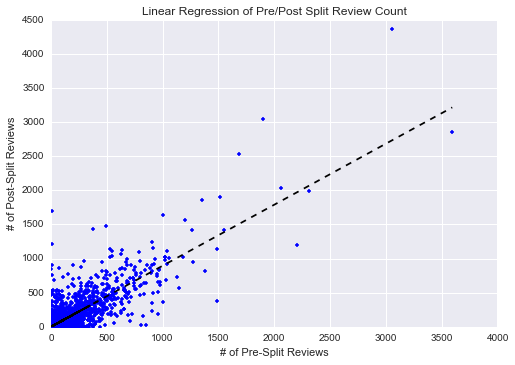

In [44]:
slope, intercept, r_value, p_value, std_err= scipy.stats.linregress(np_x[:,0], np_y_after)
print "r-squared:", r_value**2

fit = np.polyfit(np_x[:,0],np_y_after,1)
fit_fn = np.poly1d(fit)
_ = plt.plot(np_x[:,0], np_y_after, 'b.', x, fit_fn(x), '--k')
plt.ylim(0)
plt.xlabel('# of Pre-Split Reviews')
plt.ylabel('# of Post-Split Reviews')
plt.title('Linear Regression of Pre/Post Split Review Count')

While performing the linear correlation analysis, we noticed several interesting visually-identifiable, non-linear trends when plotting the following variables against the # of post-split review count:

* Number of Pre-Split Styles Reviewed
* Average Pre-Split Rating
* Average Review Length

Specifically we see the following:

* There does seem to be a positive correlation between reviewed number of styles (before) and number of reviews (after)
* Most users in our dataset give ratings around 0.7 (dense) - there is also a peak number of post-split reviews at this average
* Most users in our dataset wrote reviews around 50 words in length (dense) - there is also a peak number of post-split reviews at this average
* Users who wrote extremely long/short/positive/negative reviews have few post-split reviews (both graphs taper at the ends)

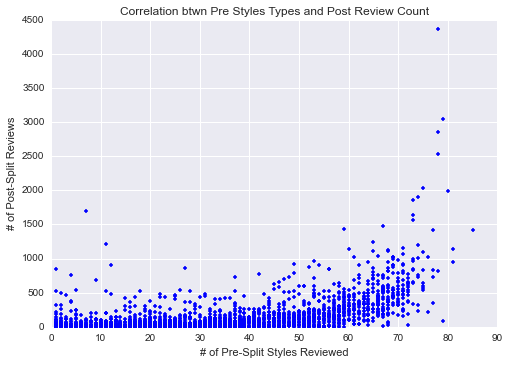

In [45]:
_ = plt.plot(np_x[:,1], np_y_after, 'b.')
plt.ylim(0)
plt.xlabel('# of Pre-Split Styles Reviewed')
plt.ylabel('# of Post-Split Reviews')
plt.title('Correlation btwn Pre Styles Types and Post Review Count')

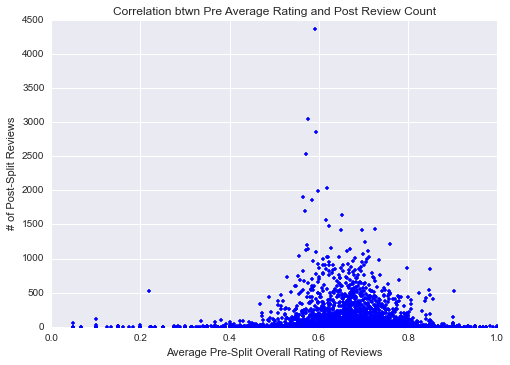

In [46]:
_= plt.plot(np_x[:,2], np_y_after, 'b.')
plt.ylim(0)
plt.xlabel('Average Pre-Split Overall Rating of Reviews')
plt.ylabel('# of Post-Split Reviews')
plt.title('Correlation btwn Pre Average Rating and Post Review Count')

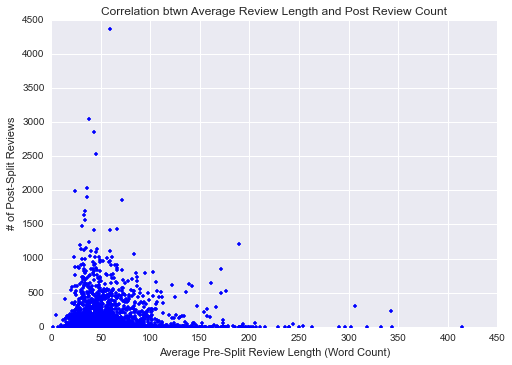

In [47]:
_= plt.plot(np_x[:,4], np_y_after, 'b.')
plt.ylim(0)
plt.xlabel('Average Pre-Split Review Length (Word Count)')
plt.ylabel('# of Post-Split Reviews')
plt.title('Correlation btwn Average Review Length and Post Review Count')

###Explore Binary Classifier
Even though no clear linear correlation is apparent to us based on our analysis so far of the select features, we thought it'd be worthwhile to test different linear classification methods with our selected feature (especially considering the potential non-linear correlation we've noticed). By doing so, we would be able to evaluate how predictive our set of features really is (based on an actual model evaluation accuracy score). 

Specifically, we were interested in whether our identified list of features could be used to predict whether a user's review contribution would increase or decrease followiing the change in the website. As we were attempting to create a positive/negative classifier, we first created a balanced pool of data to work from -- where there were an equal number of positive and negative samples (where positive/negative is determined by the user's review count plus-minus).  Following this, we split the data pool 80/20 into a training and test set. We chose to perform cross_validation (n=4) to evaluate different models and used a standard mean/standard deviation scaling to normalize our feature values. 

For the purposes of this assignment, we looked at 4 different sklearn classifiers: rbf SVM, linear SVM, dual-l2 logistic regression, non-dual-l2 logistic regression. From a cross-validation score, the model which performed best was the rbf SVM algorithm. 

Overall, this resulted in a 62% accuracy (consistent with the output from the other classifiers) -- a score that is not very good and not that much better than random. This leads us to believe that the features we selected are not strongly predictive of future review contributions to the RateBeer website. 

In [48]:
bal_data_pool = balance_pool(data_pool)
test, train = [], []
create_train_test(bal_data_pool, test, train)

train = [[user[0] for user in train], [1 if user[1] > 0 else -1 for user in train]]
test = [[user[0] for user in test], [1 if user[1] > 0 else -1 for user in test]]

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn import svm, neighbors, qda, metrics, cross_validation
from sklearn.pipeline import Pipeline

clf = Pipeline([('Scaler', StandardScaler()),
#                 ('Log-Reg', linear_model.LogisticRegression(penalty='l2', dual=True))])
#                     ('Log-Reg', linear_model.LogisticRegression(penalty='l2', dual=False))])
#                     ('SVC-linear', svm.SVC(kernel='linear'))])
                    ('SVC-rbf', svm.SVC(kernel='rbf'))])

cv = cross_validation.KFold(len(train[0]), n_folds=4, shuffle=True)
scores = cross_validation.cross_val_score(clf, train[0], train[1], cv=cv)
print "Cross Validation Scores:", scores
print "Average Cross Validation Score:", np.average(scores)
print
# peforms test on selected model
clf = clf.fit(train[0], train[1])
predicted = clf.predict(test[0])
print "Model Accuracy:", metrics.accuracy_score(test[1], predicted)
print "Confusion Matrix"
print metrics.confusion_matrix(test[1], predicted)


Cross Validation Scores: [ 0.63080169  0.62025316  0.66455696  0.62869198]
Average Cross Validation Score: 0.636075949367

Model Accuracy: 0.630801687764
Confusion Matrix
[[175  79]
 [ 96 124]]
